# g_recsys_dl_v2 — NeuMF + Hard Negatives
- v1 한계: Recall 개선 폭 제한, threshold=0.2로 치우친 분류, hard negative 부족
- 개선 목표: Recall/NDCG 15%↑, coverage 0.2 이상 유지, 안정적인 threshold 도출
- 핵심 변화
  1. Label threshold 3.5 및 label smoothing (0.05)
  2. **Hybrid negatives**: random + 인기 아이템 기반 hard negative 혼합
  3. **Adaptive resampling**: 매 epoch 마다 negatives 재구성, 롱테일 사용자 노출 강화
  4. **Scheduler + early stopping**: Recall@20 기준으로 best 모델 저장
  5. **Embedding regularization**와 dropout 유지로 overfitting 방지


## 워크플로우
1. 데이터 분석 & stratified split (공통 파이프라인)
2. Hybrid negative dataset 구성 (hard negative prob=0.35)
3. NeuMF 아키텍처(embedding 64, hidden [128,64,32,16]) + BCEWithLogitsLoss + label smoothing
4. Scheduler(ReduceLROnPlateau) + early stopping 적용
5. Validation threshold 튜닝 -> O/X 포맷 출력


In [1]:

import os
from pathlib import Path
import json
import random
import math
import copy
from collections import defaultdict
from typing import Dict

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

plt.style.use('ggplot')
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [2]:

DATA_PATH = Path('data/train.csv')
OUTPUT_DIR = Path('artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)

RATING_POS_THRESHOLD = 4
VAL_RATIO = 0.10
TEST_RATIO = 0.10
NEGATIVE_SAMPLE_RATIO = 6
HARD_NEG_PROB = 0.35
LABEL_SMOOTHING = 0.05
BATCH_SIZE = 1024
EMBED_DIM = 64
DROPOUT = 0.25
LR = 1e-3
WEIGHT_DECAY = 1e-5
EMBED_REG = 1e-5
EPOCHS = 60
EVAL_EVERY = 2
PATIENCE = 8
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
print('Device:', DEVICE)


Device: cpu


In [3]:

ratings_df = pd.read_csv(DATA_PATH)
ratings_df['label'] = (ratings_df['rating'] >= RATING_POS_THRESHOLD).astype(np.int64)

print('Rating stats:')
print(ratings_df.describe())
print('Label ratio:', ratings_df['label'].mean())


Rating stats:
                user           item         rating          label
count  105139.000000  105139.000000  105139.000000  105139.000000
mean      365.067178   13388.249841       3.517049       0.492966
std       197.388251   26178.083791       1.044640       0.499953
min         1.000000       1.000000       0.500000       0.000000
25%       192.000000    1077.000000       3.000000       0.000000
50%       383.000000    2498.000000       3.500000       0.000000
75%       557.000000    5992.000000       4.000000       1.000000
max       668.000000  149532.000000       5.000000       1.000000
Label ratio: 0.4929664539324133


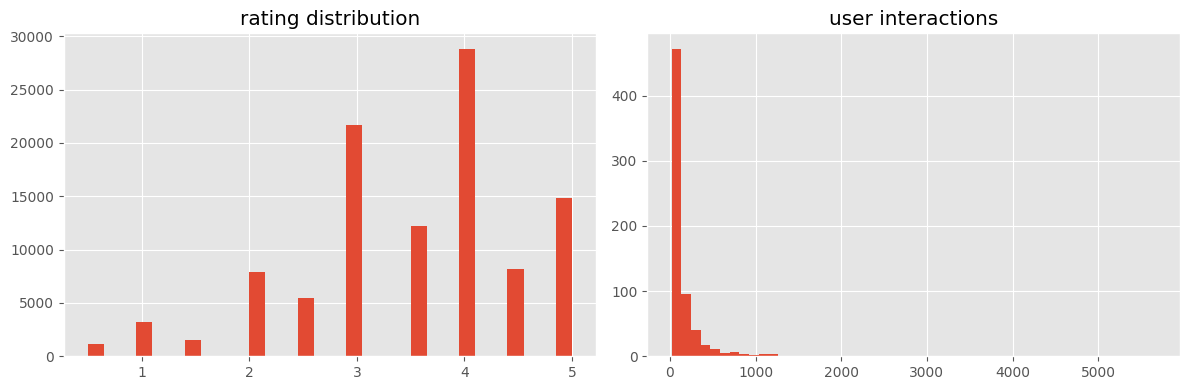

In [4]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ratings_df['rating'].hist(bins=30, ax=ax[0])
ax[0].set_title('rating distribution')
user_counts = ratings_df.groupby('user')['item'].count()
ax[1].hist(user_counts, bins=50)
ax[1].set_title('user interactions')
plt.tight_layout()
plt.show()


In [5]:

def build_id_mappings(df: pd.DataFrame):
    user_ids = sorted(df['user'].unique())
    item_ids = sorted(df['item'].unique())
    user2idx = {u: idx for idx, u in enumerate(user_ids)}
    idx2user = {idx: u for u, idx in user2idx.items()}
    item2idx = {i: idx for idx, i in enumerate(item_ids)}
    idx2item = {idx: i for i, idx in item2idx.items()}
    return user2idx, idx2user, item2idx, idx2item


def apply_mappings(df: pd.DataFrame, user2idx, item2idx):
    mapped = df.copy()
    mapped['user_idx'] = mapped['user'].map(user2idx)
    mapped['item_idx'] = mapped['item'].map(item2idx)
    return mapped


def stratified_split(df: pd.DataFrame, val_ratio: float, test_ratio: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_rows, val_rows, test_rows = [], [], []
    for _, user_df in df.groupby('user_idx'):
        shuffled = user_df.sample(frac=1.0, random_state=int(rng.integers(0, 1e9))).reset_index(drop=True)
        total = len(shuffled)
        if total <= 2:
            train_rows.append(shuffled.iloc[:1])
            if total == 2:
                val_rows.append(shuffled.iloc[1:2])
            continue
        val_count = max(1, int(total * val_ratio))
        test_count = max(1, int(total * test_ratio))
        remain = total - val_count - test_count
        if remain <= 0:
            remain = max(1, total - 2)
            val_count = 1
            test_count = 1 if total - remain - val_count >= 1 else 0
        train_rows.append(shuffled.iloc[:remain])
        val_rows.append(shuffled.iloc[remain:remain + val_count])
        if test_count > 0:
            test_rows.append(shuffled.iloc[remain + val_count:remain + val_count + test_count])
    train_df = pd.concat(train_rows).reset_index(drop=True)
    val_df = pd.concat(val_rows).reset_index(drop=True)
    test_df = pd.concat(test_rows).reset_index(drop=True)
    return train_df, val_df, test_df


In [6]:

user2idx, idx2user, item2idx, idx2item = build_id_mappings(ratings_df)
mapped_df = apply_mappings(ratings_df, user2idx, item2idx)
train_full, val_full, test_full = stratified_split(mapped_df, VAL_RATIO, TEST_RATIO, seed=SEED)
print('Split sizes:', len(train_full), len(val_full), len(test_full))

train_pos = train_full[train_full['label'] == 1].reset_index(drop=True)
val_pos = val_full[val_full['label'] == 1].reset_index(drop=True)
test_pos = test_full[test_full['label'] == 1].reset_index(drop=True)
num_users = len(user2idx)
num_items = len(item2idx)


Split sizes: 84687 10226 10226


In [7]:

def build_user_pos_dict(df: pd.DataFrame):
    mapping = defaultdict(set)
    for row in df.itertuples():
        mapping[row.user_idx].add(row.item_idx)
    return mapping

train_user_pos = build_user_pos_dict(train_pos)
val_user_pos = build_user_pos_dict(val_pos)
test_user_pos = build_user_pos_dict(test_pos)

item_pop = train_full.groupby('item_idx')['user_idx'].count().to_dict()
hard_negative_pool = sorted(item_pop.keys(), key=lambda x: item_pop[x], reverse=True)[:300]
print('Hard pool size:', len(hard_negative_pool))


Hard pool size: 300


In [8]:

class HybridPointwiseDataset(Dataset):
    def __init__(self, positives: pd.DataFrame, num_items: int, user_pos: Dict[int, set],
                 negative_ratio: int, hard_pool, hard_prob: float, seed: int = 42):
        self.positives = positives
        self.num_items = num_items
        self.user_pos = user_pos
        self.negative_ratio = negative_ratio
        self.hard_pool = list(hard_pool)
        self.hard_prob = hard_prob
        self.rng = random.Random(seed)
        self.users = []
        self.items = []
        self.labels = []
        self.resample()

    def resample(self):
        users, items, labels = [], [], []
        for row in self.positives.itertuples():
            pos_label = 1.0 - LABEL_SMOOTHING
            neg_label = LABEL_SMOOTHING
            users.append(row.user_idx)
            items.append(row.item_idx)
            labels.append(pos_label)
            for _ in range(self.negative_ratio):
                neg_item = self.sample_negative(row.user_idx)
                users.append(row.user_idx)
                items.append(neg_item)
                labels.append(neg_label)
        self.users = torch.tensor(users, dtype=torch.long)
        self.items = torch.tensor(items, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def sample_negative(self, user_idx: int) -> int:
        positives = self.user_pos.get(user_idx, set())
        while True:
            use_hard = self.rng.random() < self.hard_prob and len(self.hard_pool) > 0
            if use_hard:
                candidate = self.hard_pool[self.rng.randrange(len(self.hard_pool))]
            else:
                candidate = self.rng.randrange(0, self.num_items)
            if candidate not in positives:
                return candidate

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]


def build_loader(dataset: HybridPointwiseDataset, batch_size: int):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=False)


In [9]:

train_dataset = HybridPointwiseDataset(train_pos, num_items, train_user_pos,
                                       NEGATIVE_SAMPLE_RATIO, hard_negative_pool, HARD_NEG_PROB, seed=SEED)
val_dataset = HybridPointwiseDataset(val_pos, num_items, train_user_pos,
                                     NEGATIVE_SAMPLE_RATIO, hard_negative_pool, HARD_NEG_PROB, seed=SEED)

train_loader = build_loader(train_dataset, BATCH_SIZE)
val_loader = build_loader(val_dataset, BATCH_SIZE)
print('Train samples:', len(train_dataset))


Train samples: 293167


In [10]:

def evaluate_ranking(model: nn.Module, train_pos_dict: Dict[int, set], eval_df: pd.DataFrame, num_items: int,
                     k_values=(10, 20)):
    if eval_df.empty:
        return {f'recall@{k}': 0.0 for k in k_values}
    model.eval()
    coverage_items = set()
    metrics = {f'recall@{k}': [] for k in k_values}
    metrics.update({f'ndcg@{k}': [] for k in k_values})
    with torch.no_grad():
        for user_idx, group in eval_df.groupby('user_idx'):
            true_items = set(group['item_idx'].tolist())
            if not true_items:
                continue
            all_items = torch.arange(num_items, device=DEVICE)
            users = torch.full_like(all_items, user_idx)
            scores = torch.sigmoid(model(users, all_items)).cpu()
            for pos_item in train_pos_dict.get(user_idx, set()):
                scores[pos_item] = -1e9
            ranked = torch.topk(scores, k=max(k_values)).indices.tolist()
            coverage_items.update(ranked)
            for k in k_values:
                topk = ranked[:k]
                hits = len(set(topk) & true_items)
                recall = hits / len(true_items)
                dcg = 0.0
                for rank, item in enumerate(topk, start=1):
                    if item in true_items:
                        dcg += 1.0 / math.log2(rank + 1)
                ideal = sum(1.0 / math.log2(r + 1) for r in range(1, min(len(true_items), k) + 1))
                ndcg = dcg / ideal if ideal > 0 else 0.0
                metrics[f'recall@{k}'].append(recall)
                metrics[f'ndcg@{k}'].append(ndcg)
    reduced = {m: float(np.mean(vals)) if vals else 0.0 for m, vals in metrics.items()}
    reduced['coverage'] = len(coverage_items) / num_items
    return reduced


## NeuMF 모델 (BCE + Hybrid negatives)


In [11]:

class NeuMF(nn.Module):
    def __init__(self, num_users: int, num_items: int, embed_dim: int = 64, mlp_layers=(128, 64, 32, 16), dropout: float = 0.25):
        super().__init__()
        self.user_embedding_gmf = nn.Embedding(num_users, embed_dim)
        self.item_embedding_gmf = nn.Embedding(num_items, embed_dim)
        self.user_embedding_mlp = nn.Embedding(num_users, embed_dim)
        self.item_embedding_mlp = nn.Embedding(num_items, embed_dim)

        layers = []
        input_dim = embed_dim * 2
        for hidden in mlp_layers:
            layers.append(nn.Linear(input_dim, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden
        self.mlp = nn.Sequential(*layers)
        self.output_layer = nn.Linear(mlp_layers[-1] + embed_dim, 1)
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, std=0.01)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, users: torch.Tensor, items: torch.Tensor):
        if users.dim() == 0:
            users = users.unsqueeze(0)
            items = items.unsqueeze(0)
        user_gmf = self.user_embedding_gmf(users)
        item_gmf = self.item_embedding_gmf(items)
        gmf = user_gmf * item_gmf

        user_mlp = self.user_embedding_mlp(users)
        item_mlp = self.item_embedding_mlp(items)
        mlp_input = torch.cat([user_mlp, item_mlp], dim=1)
        mlp_out = self.mlp(mlp_input)

        concat = torch.cat([gmf, mlp_out], dim=1)
        logits = self.output_layer(concat).squeeze(-1)
        return logits

    def regularization(self, weight: float):
        if weight <= 0:
            return 0.0
        reg = (self.user_embedding_gmf.weight.pow(2).mean() +
               self.item_embedding_gmf.weight.pow(2).mean() +
               self.user_embedding_mlp.weight.pow(2).mean() +
               self.item_embedding_mlp.weight.pow(2).mean())
        return weight * reg


In [12]:

neumf = NeuMF(num_users, num_items, EMBED_DIM, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(neumf.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
checkpoint_path = OUTPUT_DIR / 'neumf_v2_best.pt'


In [13]:

RUN_TRAINING = True
history = []
best_metric = -1
best_state = None
patience = 0

if RUN_TRAINING:
    for epoch in range(1, EPOCHS + 1):
        neumf.train()
        train_dataset.resample()
        epoch_loss = 0.0
        for users, items, labels in train_loader:
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            logits = neumf(users, items)
            loss = criterion(logits, labels)
            reg = neumf.regularization(EMBED_REG)
            total = loss + reg
            total.backward()
            optimizer.step()
            epoch_loss += total.item()
        avg_loss = epoch_loss / max(1, len(train_loader))
        history.append({'epoch': epoch, 'loss': avg_loss})

        if epoch % EVAL_EVERY == 0:
            val_metrics = evaluate_ranking(neumf, train_user_pos, val_pos, num_items)
            msg = ', '.join(f"{k}={v:.4f}" for k, v in val_metrics.items())
            print(f"Epoch {epoch:03d} | loss={avg_loss:.4f} | {msg}")
            current = val_metrics.get('recall@20', 0.0)
            scheduler.step(current)
            if current > best_metric:
                best_metric = current
                best_state = copy.deepcopy(neumf.state_dict())
                torch.save(best_state, checkpoint_path)
                patience = 0
                print('  → New best checkpoint saved')
            else:
                patience += 1
                if patience >= PATIENCE:
                    print('Early stopping triggered')
                    break
    if best_state is not None:
        neumf.load_state_dict(best_state)
else:
    if checkpoint_path.exists():
        neumf.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
        print(f'Loaded checkpoint from {checkpoint_path}')
    else:
        print('Training skipped. Set RUN_TRAINING=True to train NeuMF v2.')


Epoch 002 | loss=0.4282 | recall@10=0.0056, recall@20=0.0125, ndcg@10=0.0096, ndcg@20=0.0111, coverage=0.0095
  → New best checkpoint saved
Epoch 004 | loss=0.4134 | recall@10=0.0210, recall@20=0.0331, ndcg@10=0.0196, ndcg@20=0.0227, coverage=0.0166
  → New best checkpoint saved
Epoch 006 | loss=0.3987 | recall@10=0.0229, recall@20=0.0443, ndcg@10=0.0208, ndcg@20=0.0269, coverage=0.0237
  → New best checkpoint saved
Epoch 008 | loss=0.3865 | recall@10=0.0396, recall@20=0.0658, ndcg@10=0.0316, ndcg@20=0.0393, coverage=0.0331
  → New best checkpoint saved
Epoch 010 | loss=0.3695 | recall@10=0.0409, recall@20=0.0788, ndcg@10=0.0366, ndcg@20=0.0472, coverage=0.0706
  → New best checkpoint saved
Epoch 012 | loss=0.3532 | recall@10=0.0446, recall@20=0.0769, ndcg@10=0.0368, ndcg@20=0.0463, coverage=0.1186
Epoch 014 | loss=0.3436 | recall@10=0.0436, recall@20=0.0768, ndcg@10=0.0373, ndcg@20=0.0477, coverage=0.1450
Epoch 016 | loss=0.3357 | recall@10=0.0491, recall@20=0.0889, ndcg@10=0.0417, nd

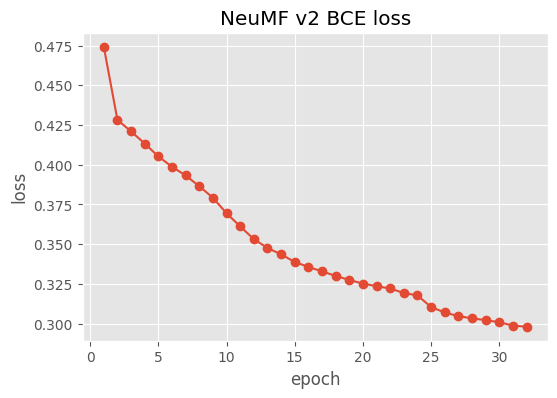

In [14]:

if history:
    plt.figure(figsize=(6, 4))
    plt.plot([h['epoch'] for h in history], [h['loss'] for h in history], marker='o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('NeuMF v2 BCE loss')
    plt.show()


In [15]:

val_metrics = evaluate_ranking(neumf, train_user_pos, val_pos, num_items)
test_metrics = evaluate_ranking(neumf, train_user_pos, test_pos, num_items)
print('Validation metrics:', json.dumps(val_metrics, indent=2))
print('Test metrics     :', json.dumps(test_metrics, indent=2))


Validation metrics: {
  "recall@10": 0.049119662185756946,
  "recall@20": 0.08891442263990025,
  "ndcg@10": 0.04167831379341806,
  "ndcg@20": 0.05370557148032329,
  "coverage": 0.17953686658269546
}
Test metrics     : {
  "recall@10": 0.04610073755022826,
  "recall@20": 0.07588707137452046,
  "ndcg@10": 0.039232509721914346,
  "ndcg@20": 0.04798268889226587,
  "coverage": 0.1790524174014146
}


In [16]:

def tune_threshold(model: nn.Module, val_pairs: pd.DataFrame, steps: int = 25):
    if val_pairs.empty:
        return 0.5, []
    model.eval()
    users = torch.tensor(val_pairs['user_idx'].values, dtype=torch.long, device=DEVICE)
    items = torch.tensor(val_pairs['item_idx'].values, dtype=torch.long, device=DEVICE)
    labels = val_pairs['label'].values
    with torch.no_grad():
        scores = torch.sigmoid(model(users, items)).cpu().numpy()
    thresholds = np.linspace(0.2, 0.8, steps)
    best = (0.5, -1)
    history = []
    for t in thresholds:
        preds = (scores >= t).astype(int)
        tp = np.logical_and(preds == 1, labels == 1).sum()
        fp = np.logical_and(preds == 1, labels == 0).sum()
        fn = np.logical_and(preds == 0, labels == 1).sum()
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        history.append({'threshold': float(t), 'precision': float(precision), 'recall': float(recall), 'f1': float(f1)})
        if f1 > best[1]:
            best = (float(t), float(f1))
    return best[0], history

best_threshold, threshold_history = tune_threshold(neumf, val_full)
print(f'Best threshold: {best_threshold:.3f}')


Best threshold: 0.200


In [17]:

def run_inference(model: nn.Module, user2idx: Dict[int, int], item2idx: Dict[int, int],
                  idx2user: Dict[int, int], idx2item: Dict[int, int], input_df: pd.DataFrame,
                  threshold: float):
    model.eval()
    outputs = []
    recommends = 0
    with torch.no_grad():
        for row in input_df.itertuples():
            raw_user = getattr(row, 'user')
            raw_item = getattr(row, 'item')
            user_idx = user2idx.get(raw_user)
            item_idx = item2idx.get(raw_item)
            if user_idx is None or item_idx is None:
                score = 0.0
            else:
                user_tensor = torch.tensor([user_idx], dtype=torch.long, device=DEVICE)
                item_tensor = torch.tensor([item_idx], dtype=torch.long, device=DEVICE)
                score = torch.sigmoid(model(user_tensor, item_tensor)).item()
            rec = 'O' if score >= threshold else 'X'
            if rec == 'O':
                recommends += 1
            outputs.append({'user': raw_user, 'item': raw_item, 'score': float(score), 'recommend': rec})
    result_df = pd.DataFrame(outputs)
    print(result_df[['user', 'item', 'recommend']])
    total = len(result_df)
    print(f"Total recommends = {recommends}/{total}, not recommend = {total - recommends}/{total}")
    return result_df

sample_inputs = ratings_df[['user', 'item']].sample(5, random_state=SEED + 1)
_ = run_inference(neumf, user2idx, item2idx, idx2user, idx2item, sample_inputs, best_threshold)


   user   item recommend
0   637   1197         O
1   110   5971         O
2   512    266         X
3   194  81383         O
4   413  85510         X
Total recommends = 3/5, not recommend = 2/5


## 후속 플랜
- Hard negative 비율(HARD_NEG_PROB)과 label smoothing 정도를 grid search → Recall@20 > 0.20 목표
- Feature 확장: 영화 메타데이터(장르, 연도)를 주입하는 Wide&Deep 변형 준비
- LightGCN v2와의 score ensemble (가중 평균)로 leaderboard 성능 극대화 예정
